In [1]:
import os
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dists
import matplotlib; matplotlib.use('Agg')  # Allows to create charts with undefined $DISPLAY
import matplotlib.pyplot as plt

from model import FullyConnected, BayesianRegression
from viz import plot_1d_posterior_predictive
from util import (
    ftens_cuda,
    to_np,
    cuda_available,
    add_output_noise,
    train_objective,
)

%matplotlib inline

def get_coverage_bounds(posterior_pred_samples, percentile):
    '''
    Assumes N x samples
    '''
    assert(not (percentile < 0. or percentile > 100.))

    lower_percentile = (100.0 - percentile) / 2.0
    upper_percentile = 100.0 - lower_percentile

    upper_bounds = np.percentile(posterior_pred_samples, upper_percentile, axis=-1)
    lower_bounds = np.percentile(posterior_pred_samples, lower_percentile, axis=-1)

    return lower_bounds, upper_bounds

def plot_1d_posterior_predictive(x_train, y_train, x_viz, y_pred):
    assert(len(x_train.shape) == 2 and x_train.shape[-1] == 1)
    assert(len(y_train.shape) == 2 and y_train.shape[-1] == 1)
    assert(len(x_viz.shape) == 2 and x_viz.shape[-1] == 1)    
    assert(len(y_pred.shape) == 2 and y_pred.shape[0] == x_viz.shape[0])

    # make sure x_viz is sorted in ascending order
    x_viz = to_np(x_viz.squeeze())
    assert(np.all(x_viz[:-1] <= x_viz[1:]))
        
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # plot predictive intervals
    for picp, alpha in zip([50.0, 68.0, 95.0], [0.4, 0.3, 0.2]):
        lower, upper = get_coverage_bounds(to_np(y_pred), picp)
        ax.fill_between(
            x_viz, lower, upper, label='{}%-PICP'.format(picp), color='steelblue', alpha=alpha,
        )

    # plot predictive mean
    pred_mean = to_np(torch.mean(y_pred, -1))        
    ax.plot(x_viz, pred_mean, color='blue', lw=3, label='Predictive Mean')

    # plot training data
    ax.scatter(x_train, y_train, color='red', s=10.0, zorder=10, label='Training Data')

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')    
    ax.set_title('Posterior Predictive')
    ax.legend()
    
    plt.show()
        
# define model
w_prior_var = 1.0 # variance of prior over weights
output_var = 0.01 # variance of observation noise
model = BayesianRegression(w_prior_var, output_var)

# set training data
N = 20
# x_train = dists.Uniform(-1.0, -0.5).sample((N/2, 1))
x_train = torch.cat((dists.Uniform(-1.0, -0.5).sample((N//2, 1)), dists.Uniform(0.5, 1).sample((N//2, 1))))
y_train = add_output_noise(torch.pow(x_train, 3.0), output_var)

# parameters of optimizer


# 1) Geoff
## Architecture (depth, width, size) affect uncertainty?
## Prior (weight initialization and prior on the bayesian part) affect uncertainty>
# Hypothesis 1: Deeper -> less variation in the functions -> less good uncertainty
# Hypothesis 2: Wider -> more variation in the functions (??) -> better uncertainties

### Papers about Bayesian Deep Ensembles..
## Bayesian Deep Ensembles via the Neural Tangent Kernel

Epoch 0: loss = 50.82194949906873
Epoch 1000: loss = 0.06683830036100424
Epoch 2000: loss = 0.05618476734376341
Epoch 3000: loss = 0.04290164289540844
Epoch 4000: loss = 0.02876931796682241
Epoch 5000: loss = 0.01739321880716543
Epoch 6000: loss = 0.011461169041378044
Epoch 7000: loss = 0.010246562854744876
Epoch 8000: loss = 0.01018475064898842
Epoch 9000: loss = 0.0101676320367813
Epoch 10000: loss = 0.010143382365084866
Epoch 11000: loss = 0.010104797123856358
Epoch 12000: loss = 0.010044191031146916
Epoch 13000: loss = 0.009954818011618193
Epoch 14000: loss = 0.009832926251148424
Epoch 15000: loss = 0.009718091599479858
Epoch 16000: loss = 0.009656481962114593
Epoch 17000: loss = 0.009563509220149627
Epoch 18000: loss = 0.009521623849937407
Epoch 19000: loss = 0.009509472704152564
Final Loss = 0.009460876379175375
Epoch 0: loss = 7.5508906307495804
Epoch 1000: loss = 0.007553285967460181
Epoch 2000: loss = 0.007471584663666738
Epoch 3000: loss = 0.007296372492669292
Epoch 4000: los

ValueError: Expected parameter precision_matrix (Tensor of shape (201, 201)) of distribution MultivariateNormal(loc: torch.Size([201]), precision_matrix: torch.Size([201, 201])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[3.8017e+16, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.5493e+16,
         8.2854e+09],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.5493e+16, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.6718e+16,
         5.1077e+09],
        [8.2854e+09, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.1077e+09,
         2.0010e+03]], grad_fn=<ExpandBackward0>)

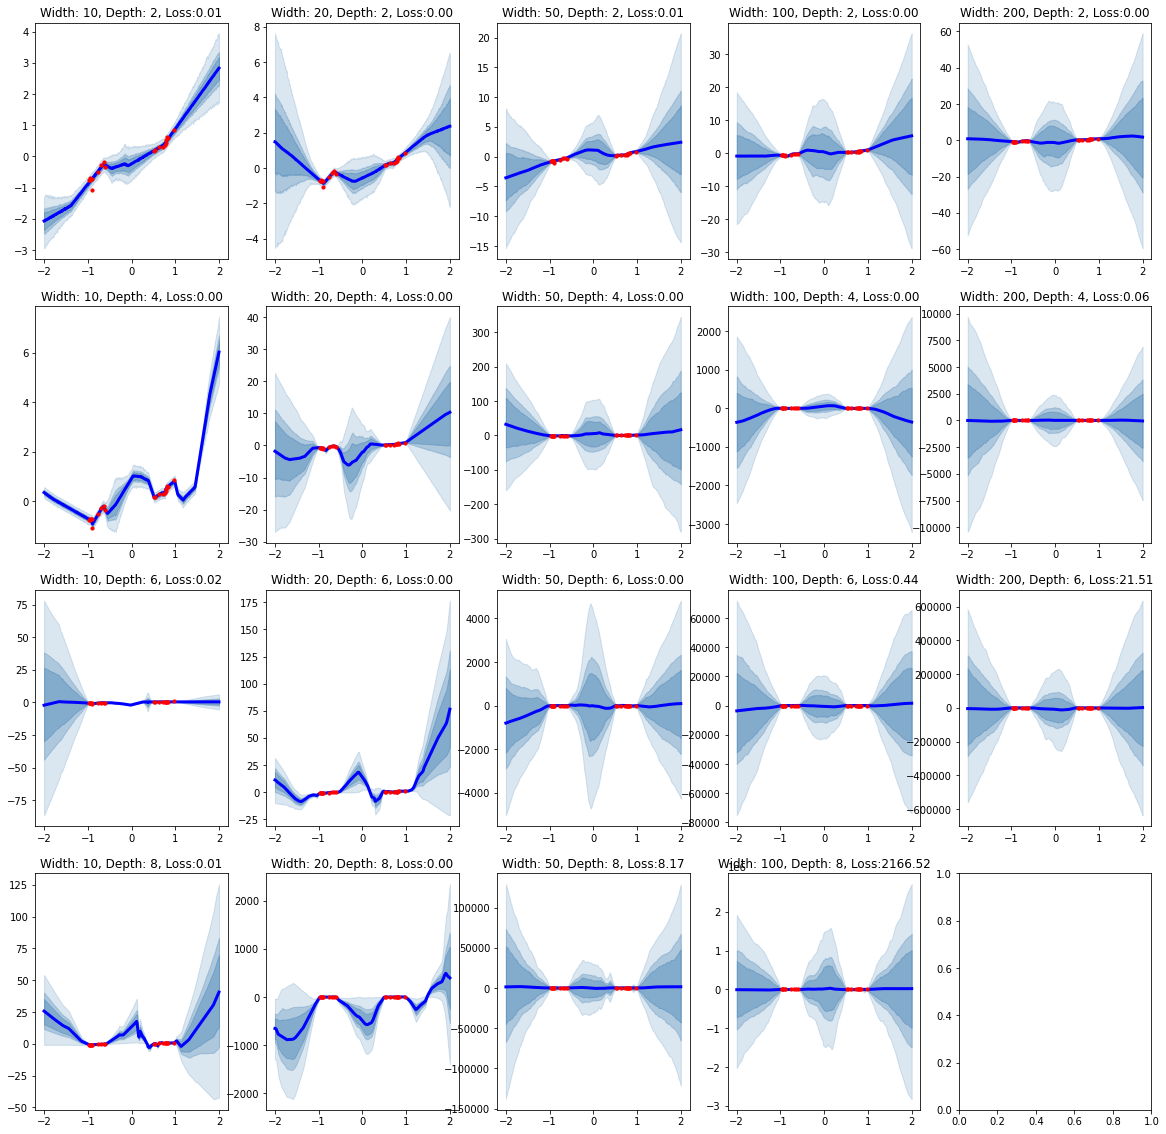

In [4]:
LEARNING_RATE = 0.001 
EPOCHS = 20000

ACTIVATION = nn.ReLU

# architecture and activation

widths = [10, 20, 50, 100, 200]
depths = [2, 4, 6, 8]
# widths = [20, 50]
# depths =[2,3]

layers_vec = []
for depth in depths:
    for width in widths:
        layers_vec.append([1] + [width]*depth + [1])
        
fig, ax = plt.subplots(len(depths), len(widths), figsize=(20, 20))
ax = ax.flatten()

for i, layers in enumerate(layers_vec):
    
    # define a neural network feature basis and final layer
    basis = FullyConnected(layers[:-1], activation_module=ACTIVATION, output_activation=True)
    final_layer = FullyConnected(layers[-2:], activation_module=ACTIVATION)

    # define MLE loss
    def mle_loss():
        y_pred = final_layer(basis(x_train))
        loss = torch.mean(torch.sum(torch.pow(final_layer(basis(x_train)) - y_train, 2.0), -1))

        return loss, (basis, final_layer)
    
        # randomly initialize basis and last layer
    basis.rand_init(math.sqrt(w_prior_var))
    final_layer.rand_init(math.sqrt(w_prior_var))

    # optimize loss to learn network
    (basis, final_layer), loss = train_objective(
        list(basis.parameters()) + list(final_layer.parameters()),
        mle_loss,
        lr=LEARNING_RATE,
        print_freq=1000,
        epochs=EPOCHS
    )

    model.infer_posterior(basis(x_train), y_train)

    # sample from posterior predictive
    x_viz = ftens_cuda(np.linspace(-2.0, 2.0, 500)).unsqueeze(-1)
    y_pred = model.sample_posterior_predictive(basis(x_viz), 500)

    # visualize posterior predictive
    x_viz = to_np(x_viz.squeeze())

    # plot predictive intervals
    for picp, alpha in zip([50.0, 68.0, 95.0], [0.4, 0.3, 0.2]):
        lower, upper = get_coverage_bounds(to_np(y_pred), picp)
        ax[i].fill_between(
            x_viz, lower, upper, label='{}%-PICP'.format(picp), color='steelblue', alpha=alpha,
        )

    # plot predictive mean
    pred_mean = to_np(torch.mean(y_pred, -1))        
    ax[i].plot(x_viz, pred_mean, color='blue', lw=3, label='Predictive Mean')

    # plot training data
    ax[i].scatter(x_train, y_train, color='red', s=10.0, zorder=10, label='Training Data')
 
    ax[i].set_title('Width: {}, Depth: {}, Loss:{:.2f}'.format(layers[1], len(layers)-2, loss))
    # ax.legend()


In [ ]:
LEARNING_RATE = 0.001 
EPOCHS = 20000

ACTIVATION = nn.ReLU

# architecture and activation

widths = [50]
depths = [2]
# widths = [20, 50]
# depths =[2,3]

layers_vec = []
for depth in depths:
    for width in widths:
        layers_vec.append([1] + [width]*depth + [1])
        
prior_vars = [0.1, 1.0, 2.0, 5.0, 10]

fig, ax = plt.subplots(len(prior_vars), 1, figsize=(20, 20))
ax = ax.flatten()

for layers in layers_vec:
    
    for i, w_prior_var in enumerate(prior_vars): 
    
        # define a neural network feature basis and final layer
        basis = FullyConnected(layers[:-1], activation_module=ACTIVATION, output_activation=True)
        final_layer = FullyConnected(layers[-2:], activation_module=ACTIVATION)

        # define MLE loss
        def mle_loss():
            y_pred = final_layer(basis(x_train))
            loss = torch.mean(torch.sum(torch.pow(final_layer(basis(x_train)) - y_train, 2.0), -1))

            return loss, (basis, final_layer)

            # randomly initialize basis and last layer
        basis.rand_init(math.sqrt(w_prior_var))
        final_layer.rand_init(math.sqrt(w_prior_var))

        # optimize loss to learn network
        (basis, final_layer), loss = train_objective(
            list(basis.parameters()) + list(final_layer.parameters()),
            mle_loss,
            lr=LEARNING_RATE,
            print_freq=10000,
            epochs=EPOCHS
        )
        
        model = BayesianRegression(w_prior_var, output_var)
        model.infer_posterior(basis(x_train), y_train)

        # sample from posterior predictive
        x_viz = ftens_cuda(np.linspace(-2.0, 2.0, 500)).unsqueeze(-1)
        y_pred = model.sample_posterior_predictive(basis(x_viz), 500)

        # visualize posterior predictive
        x_viz = to_np(x_viz.squeeze())

        # plot predictive intervals
        for picp, alpha in zip([50.0, 68.0, 95.0], [0.4, 0.3, 0.2]):
            lower, upper = get_coverage_bounds(to_np(y_pred), picp)
            ax[i].fill_between(
                x_viz, lower, upper, label='{}%-PICP'.format(picp), color='steelblue', alpha=alpha,
            )

        # plot predictive mean
        pred_mean = to_np(torch.mean(y_pred, -1))        
        ax[i].plot(x_viz, pred_mean, color='blue', lw=3, label='Predictive Mean')

        # plot training data
        ax[i].scatter(x_train, y_train, color='red', s=10.0, zorder=10, label='Training Data')

        ax[i].set_title('Prior Variance: {}, Loss:{:.2f}'.format(w_prior_var, loss))
        # ax.legend()


Epoch 0: loss = 2.219010618413331
Epoch 10000: loss = 0.0033060606659199208
Final Loss = 0.0022473049326743903
Epoch 0: loss = 462.776761333674
Epoch 10000: loss = 0.005081209453412336
